# Week 9 Lab: Decoding Strategies
## From Word Predictions to Complete Text

### Learning Goals
1. Discover why predicting one word at a time creates text quality problems
2. Learn how different decoding strategies solve these problems
3. Practice selecting and tuning methods for different use cases

### Plan for Today
1. **The challenge**: Word predictions → Complete text
2. **The toolbox**: 6 strategies for text generation
3. **Hands-on**: Compare methods in practice

## Setup: Install Dependencies and Load Model

We'll use GPT-2 (small, 124M parameters) for fast experimentation.

In [3]:
# Install required packages (uncomment if needed)
# !pip install transformers torch matplotlib numpy

import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import warnings
warnings.filterwarnings('ignore')

print('Week 9: Decoding Strategies - Simplified Lab')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Week 9: Decoding Strategies - Simplified Lab
Using device: cpu


In [4]:
# Load GPT-2 model and tokenizer
print('Loading GPT-2 model...')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
model.eval()  # Set to evaluation mode

print(f'Model loaded successfully!')
print(f'Vocabulary size: {len(tokenizer):,} words')

Loading GPT-2 model...
Model loaded successfully!
Vocabulary size: 50,257 words


## Part 1: The Challenge
### From Probabilities to Text

The model gives us probabilities for **50,000 words**. How do we choose which words to generate?

Let's see what the model predicts for a simple prompt:

In [6]:
# Show model predictions for "The cat"
prompt = "The cat"

# Encode prompt
input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits  # Raw scores

# Get probabilities for next word
next_token_logits = logits[0, -1, :]  # Last position
probs = torch.softmax(next_token_logits, dim=-1)  # Convert to probabilities

# Show top 10 most likely words
top_probs, top_indices = torch.topk(probs, 10)

print(f'Prompt: "{prompt}"')
print('\nTop 10 predictions:')
print('-' * 40)
for prob, idx in zip(top_probs, top_indices):
    word = tokenizer.decode([idx.item()])
    print(f'{word:15s} P = {prob.item():.4f}')

print('\n' + '=' * 40)
print('THE CHALLENGE: Which word should we choose?')
print('=' * 40)

Prompt: "The cat"

Top 10 predictions:
----------------------------------------
 was            P = 0.1104
 is             P = 0.0730
's              P = 0.0475
,               P = 0.0350
-               P = 0.0346
 and            P = 0.0254
 had            P = 0.0242
 has            P = 0.0231
aclysm          P = 0.0197
walk            P = 0.0192

THE CHALLENGE: Which word should we choose?


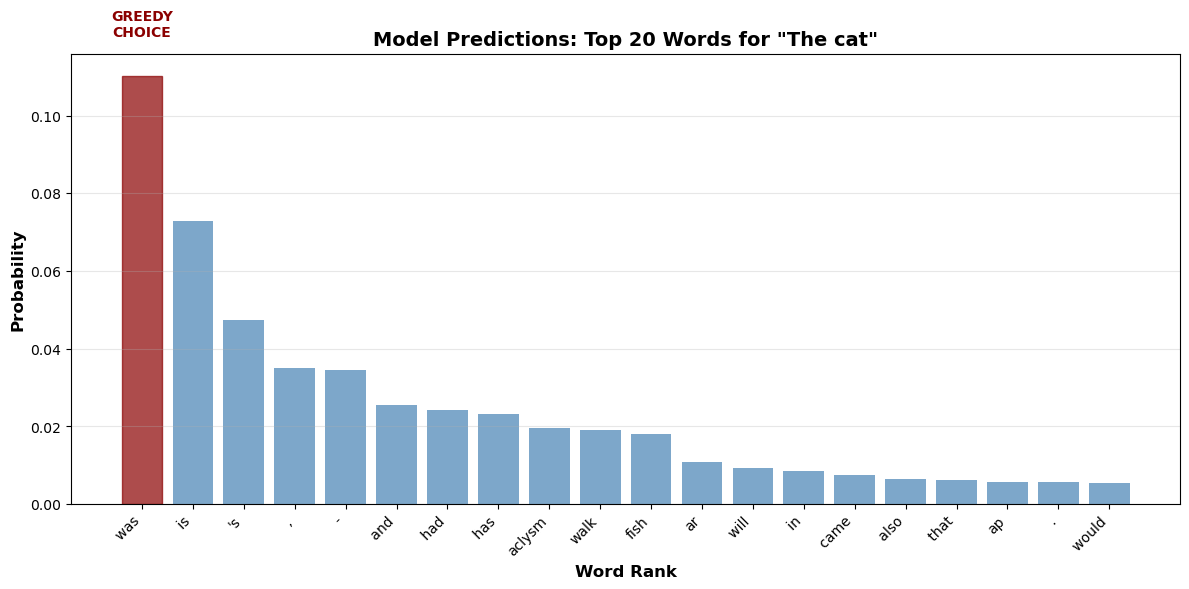

Greedy always picks: " was" (highest probability)


In [7]:
# VISUALIZATION: Probability Distribution
# Show the top 20 words as a bar chart

fig, ax = plt.subplots(figsize=(12, 6))

# Get top 20
top20_probs, top20_indices = torch.topk(probs, 20)
words = [tokenizer.decode([idx.item()]) for idx in top20_indices]
probabilities = [p.item() for p in top20_probs]

# Create bar chart
bars = ax.bar(range(20), probabilities, color='steelblue', alpha=0.7)
bars[0].set_color('darkred')  # Highlight the greedy choice

ax.set_xlabel('Word Rank', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability', fontsize=12, fontweight='bold')
ax.set_title('Model Predictions: Top 20 Words for "The cat"', fontsize=14, fontweight='bold')
ax.set_xticks(range(20))
ax.set_xticklabels(words, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# Annotate greedy choice
ax.text(0, probabilities[0] + 0.01, 'GREEDY\nCHOICE', ha='center', fontsize=10, 
       fontweight='bold', color='darkred')

plt.tight_layout()
plt.show()

print(f'Greedy always picks: "{words[0]}" (highest probability)')

## Part 2: Extreme Case 1 - Greedy Decoding (Too Narrow)

**Strategy**: Always pick the HIGHEST probability word

**Problem**: Only explores 1 path out of millions possible!

In [9]:
def greedy_decode(prompt, max_length=20):
    """
    Greedy Decoding: Always pick the most likely word.
    
    Step 1: Get probabilities from model
    Step 2: Pick word with HIGHEST probability (argmax)
    Step 3: Add to sequence and repeat
    """
    # Convert prompt to token IDs
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    
    # Generate one word at a time
    for _ in range(max_length):
        # Get model predictions
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits
        
        # Get probabilities for next word
        next_token_logits = logits[:, -1, :]  # Last position
        
        # GREEDY CHOICE: Pick the maximum probability word
        next_token = torch.argmax(next_token_logits, dim=-1)  # argmax!
        
        # Add chosen word to our sequence
        input_ids = torch.cat([input_ids, next_token.unsqueeze(-1)], dim=-1)
        
        # Stop if model generates end-of-sequence token
        if next_token.item() == tokenizer.eos_token_id:
            break
    
    # Convert token IDs back to text
    return tokenizer.decode(input_ids[0], skip_special_tokens=True)

# Test greedy decoding
test_prompt = "The cat"
output = greedy_decode(test_prompt, max_length=55)

print(f'Prompt: "{test_prompt}"')
print(f'Greedy Output: "{output}"')

Prompt: "The cat"
Greedy Output: "The cat was found in a field in the middle of the night.

The cat was found in a field in the middle of the night.

The cat was found in a field in the middle of the night.

The cat was found in a field in the"


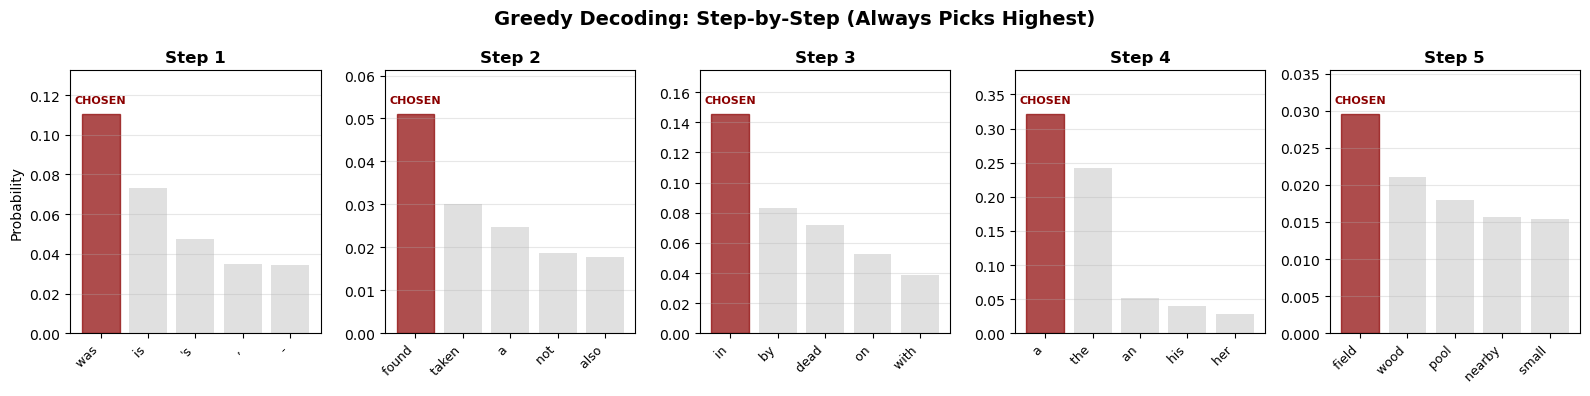

Final Output: "The cat was found in a field"


In [10]:
# VISUALIZATION: Step-by-Step Greedy Generation
# Show the deterministic path word by word

prompt_vis = "The cat"
input_ids_vis = tokenizer.encode(prompt_vis, return_tensors='pt').to(device)

# Track the generation process
generation_steps = []
for step in range(5):  # Generate 5 words
    with torch.no_grad():
        outputs = model(input_ids_vis)
        logits = outputs.logits
    
    next_token_logits = logits[:, -1, :]
    probs = torch.softmax(next_token_logits, dim=-1)
    
    # Get top 5 options - FIX: Access [0] to get the actual indices
    top5_probs, top5_ids = torch.topk(probs, 5)
    top5_words = [tokenizer.decode([top5_ids[0, i].item()]) for i in range(5)]
    top5_prob_values = [top5_probs[0, i].item() for i in range(5)]
    
    # Greedy picks the first one
    chosen_word = top5_words[0]
    chosen_prob = top5_prob_values[0]
    
    generation_steps.append({
        'step': step + 1,
        'options': list(zip(top5_words, top5_prob_values)),
        'chosen': chosen_word,
        'chosen_prob': chosen_prob
    })
    
    # Add chosen token
    next_token = top5_ids[0, 0].unsqueeze(0).unsqueeze(0)
    input_ids_vis = torch.cat([input_ids_vis, next_token], dim=-1)

# Visualize the process
fig, axes = plt.subplots(1, 5, figsize=(16, 4))

for i, step_data in enumerate(generation_steps):
    ax = axes[i]
    
    # Extract options
    words, probs = zip(*step_data['options'])
    
    # Bar chart
    bars = ax.bar(range(5), probs, color='lightgray', alpha=0.7)
    bars[0].set_color('darkred')  # Highlight chosen word
    
    ax.set_title(f"Step {step_data['step']}", fontsize=12, fontweight='bold')
    ax.set_ylabel('Probability' if i == 0 else '', fontsize=10)
    ax.set_xticks(range(5))
    ax.set_xticklabels(words, rotation=45, ha='right', fontsize=9)
    ax.set_ylim(0, max(probs) * 1.2)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Show chosen word
    ax.text(0, probs[0] * 1.05, 'CHOSEN', ha='center', fontsize=8, 
           fontweight='bold', color='darkred')

plt.suptitle('Greedy Decoding: Step-by-Step (Always Picks Highest)', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Show final sequence
final_text = tokenizer.decode(input_ids_vis[0], skip_special_tokens=True)
print(f'Final Output: "{final_text}"')

In [11]:
# EXPERIMENT: Run greedy 5 times
# Observation: Output is ALWAYS the same (deterministic)

print('Running greedy decoding 5 times...')
print('=' * 60)

for i in range(5):
    output = greedy_decode("The cat", max_length=10)
    print(f'Run {i+1}: {output}')

print('=' * 60)
print('OBSERVATION: Greedy always produces the SAME output!')
print('This is the "Too Narrow" problem - only 1 path explored.')

Running greedy decoding 5 times...
Run 1: The cat was found in a field in the middle of the
Run 2: The cat was found in a field in the middle of the
Run 3: The cat was found in a field in the middle of the
Run 4: The cat was found in a field in the middle of the
Run 5: The cat was found in a field in the middle of the
OBSERVATION: Greedy always produces the SAME output!
This is the "Too Narrow" problem - only 1 path explored.


## Part 3: Extreme Case 2 - Full Search (Too Broad)

**Strategy**: Explore ALL possible word combinations

**Problem**: With 50,000 vocabulary and 5 words:
- Total paths = 50,000^5 = **3.125 trillion paths**
- Computationally IMPOSSIBLE!

We won't implement this (it would crash), but understand: we need something **in between** greedy and full search.

## Part 4: The Toolbox - 6 Practical Methods

We'll implement and test 6 methods that balance quality and speed:

1. **Greedy** - Fastest, deterministic
2. **Beam Search** - Keeps k best paths
3. **Temperature** - Controls randomness
4. **Top-k** - Samples from k most likely words
5. **Nucleus (Top-p)** - Samples from cumulative probability p
6. **Contrastive** - Penalizes repetition explicitly

### Method 1: Greedy Decoding
(Already implemented above)

### Method 2: Beam Search

Keep track of the **k best paths** (not just 1 like greedy).

In [16]:
def beam_search(prompt, beam_size=3, max_length=20):
    """Beam Search: Keep k best paths."""
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    beams = [(input_ids, 0.0)]
    
    for _ in range(max_length):
        all_candidates = []
        
        for seq, score in beams:
            with torch.no_grad():
                outputs = model(seq)
                logits = outputs.logits
            
            next_token_logits = logits[:, -1, :]
            log_probs = torch.log_softmax(next_token_logits, dim=-1)
            top_k_log_probs, top_k_ids = torch.topk(log_probs, beam_size)
            
            for i in range(beam_size):
                next_token = top_k_ids[0, i].unsqueeze(0).unsqueeze(0)
                next_score = score + top_k_log_probs[0, i].item()
                next_seq = torch.cat([seq, next_token], dim=-1)
                all_candidates.append((next_seq, next_score))
        
        ordered = sorted(all_candidates, key=lambda x: x[1], reverse=True)
        beams = ordered[:beam_size]
        
        if beams[0][0][0, -1].item() == tokenizer.eos_token_id:
            break
    
    return tokenizer.decode(beams[0][0][0], skip_special_tokens=True)

# Test
print('Beam Search:')
print(f'Greedy:  {greedy_decode("The cat", 10)}')
print(f'Beam-3:  {beam_search("The cat", 3, 10)}')
print(f'Beam-5:  {beam_search("The cat", 5, 10)}')

Beam Search:
Greedy:  The cat was found in a field in the middle of the
Beam-3:  The cat was taken to a local hospital, where it was
Beam-5:  The cat-and-mouse game.

It's


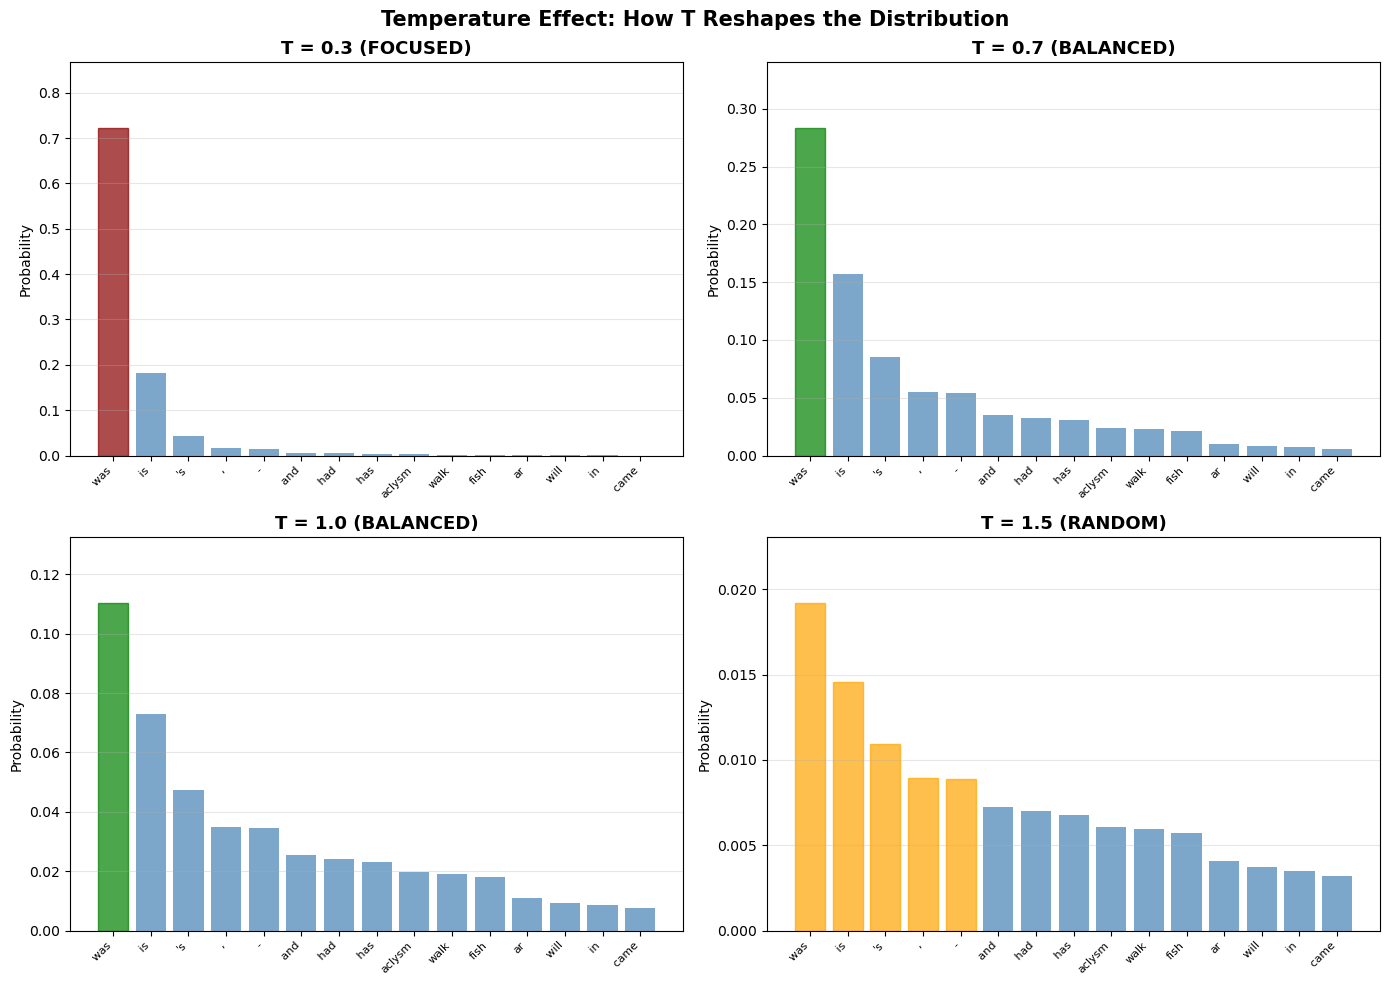

KEY INSIGHT: T<1 = Sharp peak, T>1 = Flat distribution


In [17]:
# VISUALIZATION: Temperature Effect on Probability Distribution
prompt_temp = "The cat"
input_ids_temp = tokenizer.encode(prompt_temp, return_tensors='pt').to(device)

with torch.no_grad():
    outputs = model(input_ids_temp)
    logits = outputs.logits

next_token_logits = logits[0, -1, :]

# Test different temperatures
temps = [0.3, 0.7, 1.0, 1.5]  # Fixed: was .0 instead of 1.0
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, temp in enumerate(temps):
    ax = axes[idx]
    
    scaled_logits = next_token_logits / temp
    probs_temp = torch.softmax(scaled_logits, dim=-1)
    
    top15_probs, top15_ids = torch.topk(probs_temp, 15)
    # FIX: These are 1D tensors, not 2D
    words = [tokenizer.decode([top15_ids[i].item()]) for i in range(15)]
    prob_values = [top15_probs[i].item() for i in range(15)]
    
    bars = ax.bar(range(15), prob_values, color='steelblue', alpha=0.7)
    
    if temp < 0.7:
        bars[0].set_color('darkred')
        description = 'FOCUSED'
    elif temp > 1.0:
        for bar in bars[:5]:
            bar.set_color('orange')
        description = 'RANDOM'
    else:
        bars[0].set_color('green')
        description = 'BALANCED'
    
    ax.set_title(f'T = {temp} ({description})', fontsize=13, fontweight='bold')
    ax.set_xticks(range(15))
    ax.set_xticklabels(words, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Probability', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, max(prob_values) * 1.2)

plt.suptitle('Temperature Effect: How T Reshapes the Distribution', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print('KEY INSIGHT: T<1 = Sharp peak, T>1 = Flat distribution')

In [18]:
def top_k_sampling(prompt, k=50, temperature=0.8, max_length=20):
    """Top-k Sampling: Sample from top-k words only."""
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    
    for _ in range(max_length):
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits
        
        next_token_logits = logits[:, -1, :] / temperature
        top_k_logits, top_k_indices = torch.topk(next_token_logits, k)
        probs = torch.softmax(top_k_logits, dim=-1)
        next_token_idx = torch.multinomial(probs, num_samples=1)
        next_token = top_k_indices[0, next_token_idx]  # This gives us the token ID
        input_ids = torch.cat([input_ids, next_token], dim=-1)  # FIX: Don't unsqueeze again
        
        if next_token.item() == tokenizer.eos_token_id:
            break
    
    return tokenizer.decode(input_ids[0], skip_special_tokens=True)

# Test
print('Top-k Sampling:')
for k in [5, 20, 50]:
    print(f'k={k}: {top_k_sampling("The cat", k, 0.8, 10)}')

Top-k Sampling:
k=5: The cat was taken to hospital, where it was pronounced dead
k=20: The cat, which was born in the US in 1984,
k=50: The cat was a bit short on legs and the tail of


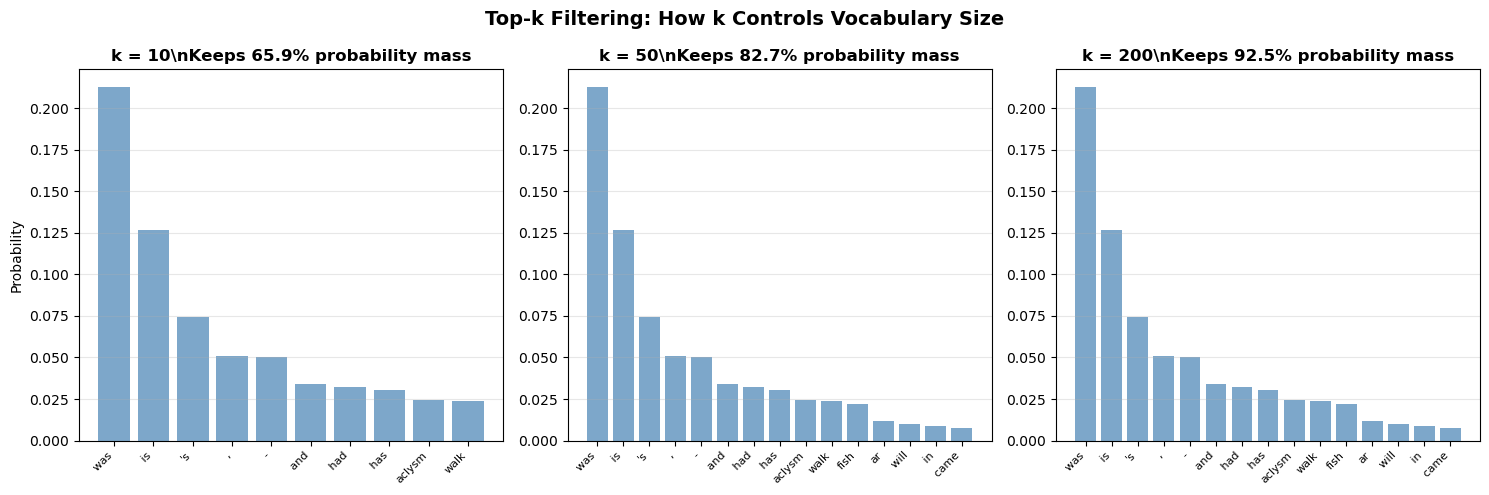

KEY INSIGHT: Smaller k = More focused, Larger k = More diverse


In [19]:
# VISUALIZATION: Top-k Filtering Effect
# Show probability mass before and after filtering

prompt_topk = "The cat"
input_ids = tokenizer.encode(prompt_topk, return_tensors='pt').to(device)

with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits

next_token_logits = logits[0, -1, :] / 0.8  # Apply temperature
probs_full = torch.softmax(next_token_logits, dim=-1)

# Compare different k values
k_tests = [10, 50, 200]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, k in enumerate(k_tests):
    ax = axes[idx]
    
    # Get top-k
    topk_probs, topk_ids = torch.topk(probs_full, k)
    words_topk = [tokenizer.decode([i.item()]) for i in topk_ids[:15]]  # Show first 15
    
    # Calculate probability mass
    prob_mass = topk_probs.sum().item()
    filtered_mass = 1.0 - prob_mass
    
    # Bar chart for top 15 words
    bars = ax.bar(range(min(15, k)), [topk_probs[i].item() for i in range(min(15, k))],
                 color='steelblue', alpha=0.7)
    
    ax.set_title(f'k = {k}\\nKeeps {prob_mass*100:.1f}% probability mass', 
                fontsize=12, fontweight='bold')
    ax.set_xticks(range(min(15, k)))
    ax.set_xticklabels(words_topk, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Probability' if idx == 0 else '', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Top-k Filtering: How k Controls Vocabulary Size', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('KEY INSIGHT: Smaller k = More focused, Larger k = More diverse')

In [20]:
def temperature_sampling(prompt, temperature=1.0, max_length=20):
    """
    Temperature Sampling: Scale probabilities to control randomness.
    
    Formula: P_new = softmax(logits / T)
    
    - T=0.1: Almost greedy (very focused)
    - T=0.7: Moderate randomness (common for dialogue)
    - T=1.0: Original distribution
    - T=1.5: Very random (creative writing)
    """
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    
    for _ in range(max_length):
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits
        
        next_token_logits = logits[:, -1, :]
        
        # Apply temperature scaling
        scaled_logits = next_token_logits / temperature
        
        # Get probabilities
        probs = torch.softmax(scaled_logits, dim=-1)
        
        # Sample from distribution (not argmax!)
        next_token = torch.multinomial(probs, num_samples=1)
        
        input_ids = torch.cat([input_ids, next_token], dim=-1)
        
        if next_token.item() == tokenizer.eos_token_id:
            break
    
    return tokenizer.decode(input_ids[0], skip_special_tokens=True)

# Test different temperatures
test_prompt = "The cat"
temperatures = [0.3, 0.7, 1.0, 1.5]

print('Temperature Comparison:')
print('=' * 60)
print(f'Prompt: "{test_prompt}"\n')

for temp in temperatures:
    output = temperature_sampling(test_prompt, temperature=temp, max_length=15)
    print(f'T={temp:<4}: {output}')

print('\nOBSERVATION: Higher T → More creative (and random)!')

Temperature Comparison:
Prompt: "The cat"

T=0.3 : The cat's name is the name of the cat's owner.

The cat
T=0.7 : The cat-like creature's head appears to be planted in an area the size of
T=1.0 : The cat was searched the next day carrying old guns, cash and the Koran.

T=1.5 : The cat tore off EskDavis shelter genitals, constantly roughening Petersdin MED

OBSERVATION: Higher T → More creative (and random)!


In [21]:
# Diversity and Quality Metrics
def calculate_diversity(text, n=2):
    """Calculate Distinct-n: unique n-grams / total n-grams."""
    words = text.split()
    ngrams = [tuple(words[i:i+n]) for i in range(len(words)-n+1)]
    if len(ngrams) == 0:
        return 0.0
    return len(set(ngrams)) / len(ngrams)

def count_repetition(text, n=3):
    """Count repeated n-grams."""
    words = text.split()
    ngrams = [tuple(words[i:i+n]) for i in range(len(words)-n+1)]
    if len(ngrams) == 0:
        return 0.0
    unique = len(set(ngrams))
    total = len(ngrams)
    return (1 - unique / total) * 100

print('Metrics defined!')

Metrics defined!


### Method 5: Nucleus Sampling (Top-p)

**Idea**: Sample from the **smallest set of words** whose cumulative probability ≥ p

**Advantage**: Adapts to the distribution!
- When model is confident: Small nucleus (few words)
- When model is uncertain: Large nucleus (many words)

**This is what GPT-4, ChatGPT, and Claude use!**

In [ ]:
def nucleus_sampling(prompt, p=0.9, temperature=0.8, max_length=20):
    """Nucleus (Top-p) Sampling: Sample from smallest set with cumulative P >= p."""
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    
    for _ in range(max_length):
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits
        
        next_token_logits = logits[:, -1, :] / temperature
        probs = torch.softmax(next_token_logits, dim=-1)
        
        # Sort probabilities (descending)
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        
        # Find cumulative sum
        cumsum_probs = torch.cumsum(sorted_probs, dim=-1)
        
        # Find where cumsum >= p (this is our nucleus)
        cutoff_idx = torch.where(cumsum_probs >= p)[0][0] + 1
        
        # Keep only nucleus
        nucleus_probs = sorted_probs[:, :cutoff_idx]
        nucleus_indices = sorted_indices[:, :cutoff_idx]
        
        # Renormalize (probabilities should sum to 1)
        nucleus_probs = nucleus_probs / nucleus_probs.sum()
        
        # Sample from nucleus (torch.multinomial is stochastic by default)
        next_token_idx = torch.multinomial(nucleus_probs, num_samples=1)
        next_token = nucleus_indices[0, next_token_idx]
        
        input_ids = torch.cat([input_ids, next_token], dim=-1)
        
        if next_token.item() == tokenizer.eos_token_id:
            break
    
    return tokenizer.decode(input_ids[0], skip_special_tokens=True)

# Test different p values - Multiple samples to show stochasticity
test_prompt = "The cat"
p_values = [0.5, 0.9, 0.95]

print('Nucleus (Top-p) Comparison:')
print('=' * 70)
print('NOTE: Sampling methods produce DIFFERENT outputs each run')
print('=' * 70)

for p in p_values:
    print(f'\np={p} (3 samples):')
    for i in range(3):
        output = nucleus_sampling(test_prompt, p=p, temperature=0.8, max_length=10)
        print(f'  {i+1}. {output}')

print('\nOBSERVATION: Nucleus is stochastic - different every time!')

COMPARING ALL METHODS

Greedy         : Once upon a time, the world was a place of great beauty and great danger. The world
  Diversity: 1.000 | Repetition: 0.0%
----------------------------------------------------------------------

Beam-3         : Once upon a time, it was said that the Lord had said to Moses, "I will
  Diversity: 1.000 | Repetition: 0.0%
----------------------------------------------------------------------

Temp=0.7       : Once upon a time, we are in the process of setting up a new name for our organization
  Diversity: 1.000 | Repetition: 0.0%
----------------------------------------------------------------------

Top-k=40       : Once upon a time, he had thought of having killed the king himself.

And it
  Diversity: 1.000 | Repetition: 0.0%
----------------------------------------------------------------------

Nucleus p=0.9  : Once upon a time, the world was a place of great beauty and great danger. The world
  Diversity: 1.000 | Repetition: 0.0%
-------------

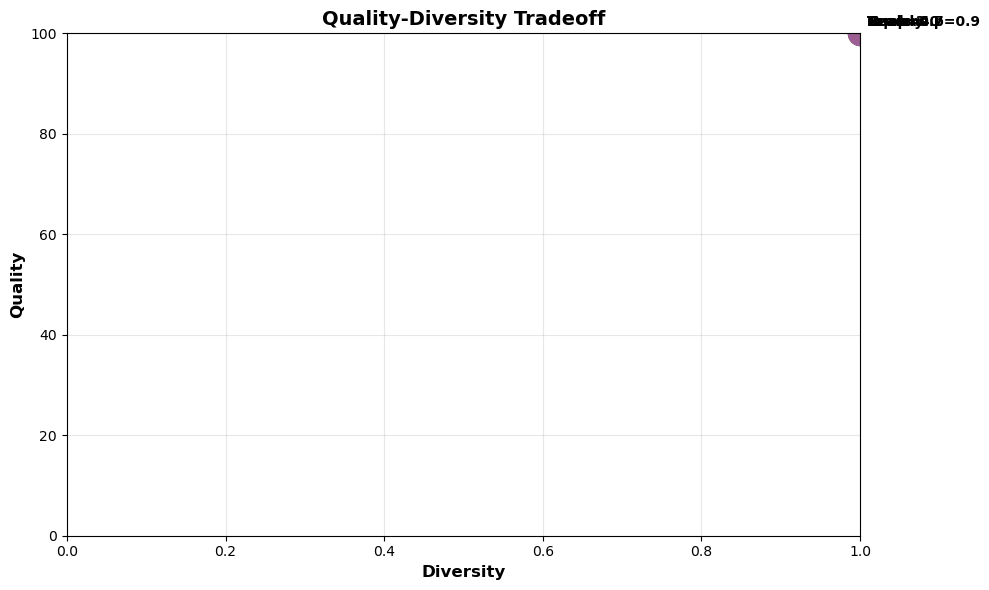


KEY INSIGHT: Top-right corner = Best!


In [24]:
# Compare All Methods
import pandas as pd

prompt = "Once upon a time"

print('COMPARING ALL METHODS')
print('=' * 70)

results = {
    'Greedy': greedy_decode(prompt, 15),
    'Beam-3': beam_search(prompt, 3, 15),
    'Temp=0.7': temperature_sampling(prompt, 0.7, 15),
    'Top-k=40': top_k_sampling(prompt, 40, 0.8, 15),
    'Nucleus p=0.9': nucleus_sampling(prompt, 0.9, 0.8, 15),
}

method_stats = []
for method, output in results.items():
    div = calculate_diversity(output, 2)
    rep = count_repetition(output, 3)
    print(f'\n{method:15s}: {output}')
    print(f'  Diversity: {div:.3f} | Repetition: {rep:.1f}%')
    method_stats.append({'method': method, 'diversity': div, 'quality': 100-rep})
    print('-' * 70)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
for stats in method_stats:
    ax.scatter(stats['diversity'], stats['quality'], s=300, alpha=0.7)
    ax.annotate(stats['method'], (stats['diversity'], stats['quality']),
               xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')

ax.set_xlabel('Diversity', fontsize=12, fontweight='bold')
ax.set_ylabel('Quality', fontsize=12, fontweight='bold')
ax.set_title('Quality-Diversity Tradeoff', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 100)
plt.tight_layout()
plt.show()

print('\nKEY INSIGHT: Top-right corner = Best!')

Testing Temperature sensitivity...
Testing Top-k sensitivity...
Testing Nucleus (p) sensitivity...


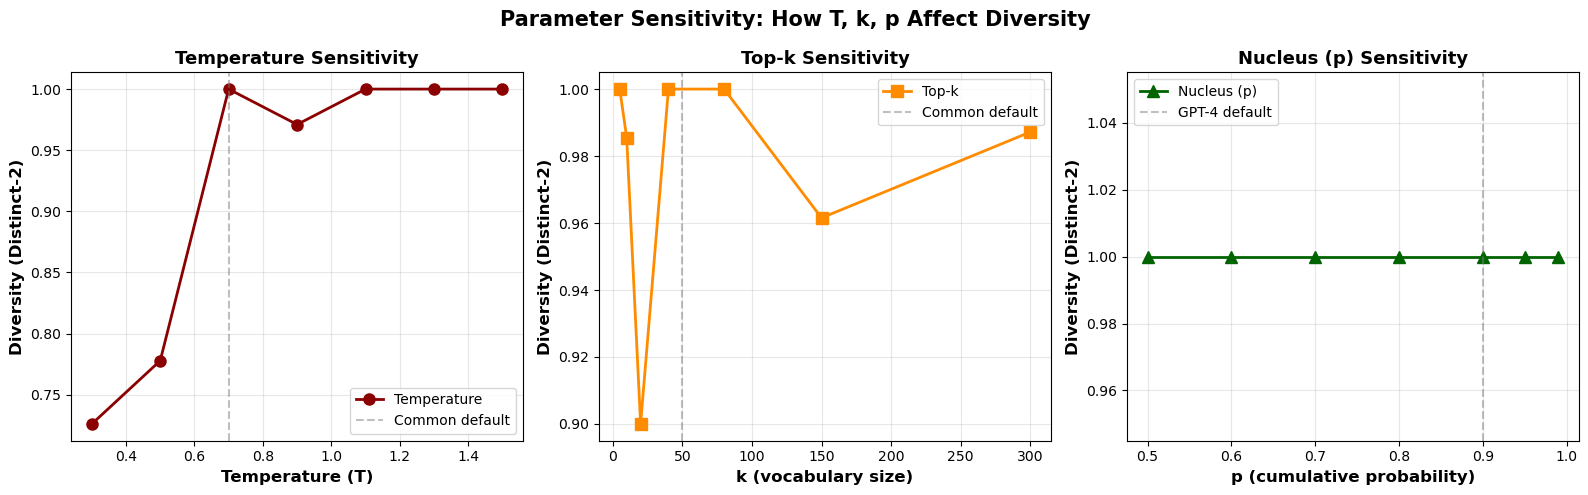


KEY FINDINGS:
- Temperature: Linear relationship (higher T = higher diversity)
- Top-k: Diminishing returns after k=50-100
- Nucleus: Gradual increase, p=0.9-0.95 is sweet spot


In [25]:
# VISUALIZATION: Parameter Sensitivity
# Test how T, k, and p affect diversity

test_prompt_param = "The future is"

# Test Temperature sensitivity
print('Testing Temperature sensitivity...')
temp_range = [0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
temp_diversities = []

for temp in temp_range:
    outputs = [temperature_sampling(test_prompt_param, temp, 25) for _ in range(3)]
    avg_div = np.mean([calculate_diversity(out, 2) for out in outputs])
    temp_diversities.append(avg_div)

# Test Top-k sensitivity
print('Testing Top-k sensitivity...')
k_range = [5, 10, 20, 40, 80, 150, 300]
k_diversities = []

for k in k_range:
    outputs = [top_k_sampling(test_prompt_param, k, 0.8, 25) for _ in range(3)]
    avg_div = np.mean([calculate_diversity(out, 2) for out in outputs])
    k_diversities.append(avg_div)

# Test Nucleus sensitivity
print('Testing Nucleus (p) sensitivity...')
p_range = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
p_diversities = []

for p in p_range:
    outputs = [nucleus_sampling(test_prompt_param, p, 0.8, 25) for _ in range(3)]
    avg_div = np.mean([calculate_diversity(out, 2) for out in outputs])
    p_diversities.append(avg_div)

# Plot all three
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Temperature
axes[0].plot(temp_range, temp_diversities, marker='o', linewidth=2, 
            markersize=8, color='darkred', label='Temperature')
axes[0].axvline(x=0.7, color='gray', linestyle='--', alpha=0.5, label='Common default')
axes[0].set_xlabel('Temperature (T)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Diversity (Distinct-2)', fontsize=12, fontweight='bold')
axes[0].set_title('Temperature Sensitivity', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Top-k
axes[1].plot(k_range, k_diversities, marker='s', linewidth=2, 
            markersize=8, color='darkorange', label='Top-k')
axes[1].axvline(x=50, color='gray', linestyle='--', alpha=0.5, label='Common default')
axes[1].set_xlabel('k (vocabulary size)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Diversity (Distinct-2)', fontsize=12, fontweight='bold')
axes[1].set_title('Top-k Sensitivity', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Nucleus
axes[2].plot(p_range, p_diversities, marker='^', linewidth=2, 
            markersize=8, color='darkgreen', label='Nucleus (p)')
axes[2].axvline(x=0.9, color='gray', linestyle='--', alpha=0.5, label='GPT-4 default')
axes[2].set_xlabel('p (cumulative probability)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Diversity (Distinct-2)', fontsize=12, fontweight='bold')
axes[2].set_title('Nucleus (p) Sensitivity', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.suptitle('Parameter Sensitivity: How T, k, p Affect Diversity', 
            fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print('\nKEY FINDINGS:')
print('- Temperature: Linear relationship (higher T = higher diversity)')
print('- Top-k: Diminishing returns after k=50-100')
print('- Nucleus: Gradual increase, p=0.9-0.95 is sweet spot')

## Exercises for Students

### Exercise 1: Fix Repetitive Text
The greedy output below is repetitive. Which method would fix it?

In [30]:
# Repetitive greedy output
repetitive_prompt = "The robot said"
bad_output = greedy_decode(repetitive_prompt, max_length=40)

print('PROBLEM: Repetitive output')
print('=' * 60)
print(f'Greedy: {bad_output}')
print(f'Repetition rate: {count_repetition(bad_output, 3):.1f}%')
print('\n' + '-' * 60)

# YOUR TURN: Try different methods to reduce repetition
# Uncomment and test:

# better_output = temperature_sampling(repetitive_prompt, temperature=0.8, max_length=40)
# print(f'Temperature: {better_output}')
# print(f'Repetition rate: {count_repetition(better_output, 3):.1f}%')

# Or try:
# better_output = nucleus_sampling(repetitive_prompt, p=0.9, temperature=0.8, max_length=40)
# print(f'Nucleus: {better_output}')
# print(f'Repetition rate: {count_repetition(better_output, 3):.1f}%')

PROBLEM: Repetitive output
Greedy: The robot said it was able to detect the presence of a "very large number of people" in the area.

The robot said it was able to detect the presence of a "very large number of people
Repetition rate: 40.0%

------------------------------------------------------------


### Exercise 2: Choose the Right Method

For each task below, which method would you use?

In [32]:
# Task 1: Factual Question
factual_prompt = "The capital of Germany is"

# YOUR TURN: Which method is best for factual accuracy?
# Option A: Greedy
# Option B: High temperature sampling (T=1.5)
# Option C: Nucleus sampling

# Uncomment your choice:
# output1 = greedy_decode(factual_prompt, 10)
# output1 = temperature_sampling(factual_prompt, 1.5, 10)
# output1 = nucleus_sampling(factual_prompt, 0.9, 0.8, 10)

# print(f'Task 1 output: {output1}')

print('Try different methods and see which gives the correct answer!')

Try different methods and see which gives the correct answer!


In [33]:
# Task 2: Creative Story
creative_prompt = "In a mysterious forest"

# YOUR TURN: Which method creates the most engaging story?
# Try greedy, then try nucleus with different temperatures

# Example:
# boring_story = greedy_decode(creative_prompt, 40)
# creative_story = nucleus_sampling(creative_prompt, p=0.95, temperature=1.0, max_length=40)

# print('Greedy (boring):', boring_story)
# print('\nNucleus (creative):', creative_story)

print('Experiment with different methods and parameters!')

Experiment with different methods and parameters!


## Summary: What We Learned

### The Core Challenge
- Models predict **one word at a time**
- We need to convert these predictions into **coherent text**
- This is called **decoding**

### The 5 Methods We Implemented

1. **Greedy**: Pick highest probability word
   - Fast, deterministic
   - Problem: Repetitive

2. **Beam Search**: Keep k best paths
   - Better than greedy
   - Problem: Still deterministic

3. **Temperature**: Scale probabilities
   - T<1: More focused
   - T>1: More random

4. **Top-k**: Sample from k most likely words
   - Fixed vocabulary size
   - Simple to understand

5. **Nucleus (Top-p)**: Sample from cumulative probability p
   - Adapts to distribution
   - **Most popular choice** (used by GPT-4, ChatGPT, Claude)

### Recommended Settings

If you're unsure, start with:
- **p = 0.9** (nucleus)
- **T = 0.7** (temperature)

Then adjust based on your task!

### Next Steps
- Experiment with the existing comprehensive notebook: `week09_decoding_lab.ipynb`
- Try implementing Contrastive Search (Method 6) for long text generation
- Learn about fine-tuning in Week 10